# Global Optimizers tests

## Scipy

#### Dual Annealing

In [ ]:
from scipy.optimize import dual_annealing
import numpy as np

func = lambda x: np.sum(x*x - 10*np.cos(2*np.pi*x)) + 10*np.size(x)
lw = [-5.12] * 10
up = [5.12] * 10

In [ ]:
ret = dual_annealing(func, bounds=list(zip(lw, up)), seed=1234)
print("global minimum: xmin = {0}, f(xmin) = {1:.6f}".format(ret.x, ret.fun))

#### Simplicial Homology Global Optimization (SHGO)

In [ ]:
from scipy.optimize import rosen, shgo
bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]

Bounded:

In [ ]:
result = shgo(rosen, bounds)
result.x, result.fun

Empty bounds:

In [ ]:
bounds = [(None, None), ]*4
result = shgo(rosen, bounds)
result.x

Egg holder function (many local minima, one global minimum):

In [ ]:
def eggholder(x):
    return (-(x[1] + 47.0)
            * np.sin(np.sqrt(abs(x[0]/2.0 + (x[1] + 47.0))))
            - x[0] * np.sin(np.sqrt(abs(x[0] - (x[1] + 47.0))))
            )
bounds = [(-512, 512), (-512, 512)]

In [ ]:
result = shgo(eggholder, bounds, n=30, sampling_method='sobol')
result.xl, result.funl

In [ ]:
result_2 = shgo(eggholder, bounds, n=60, iters=5, sampling_method='sobol')
len(result.xl), len(result_2.xl)

#### Basin Hopping

In [ ]:
from scipy.optimize import basinhopping
func = lambda x: np.cos(14.5 * x - 0.3) + (x + 0.2) * x
x0=[1.]

In [ ]:
minimizer_kwargs = {"method": "BFGS"}
ret = basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs, niter=200)
print("global minimum: x = %.4f, f(x0) = %.4f" % (ret.x, ret.fun))

2D minimization problem:

In [ ]:
def func2d(x):
    f = np.cos(14.5 * x[0] - 0.3) + (x[1] + 0.2) * x[1] + (x[0] + 0.2) * x[0]
    df = np.zeros(2)
    df[0] = -14.5 * np.sin(14.5 * x[0] - 0.3) + 2. * x[0] + 0.2
    df[1] = 2. * x[1] + 0.2
    return f, df

In [ ]:
minimizer_kwargs = {"method":"L-BFGS-B", "jac":True}
x0 = [1.0, 1.0]
ret = basinhopping(func2d, x0, minimizer_kwargs=minimizer_kwargs, niter=200)
print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (ret.x[0],
                                                          ret.x[1],
                                                          ret.fun))

Prints output at every step:

In [ ]:
def print_fun(x, f, accepted):
        print("at minimum %.4f accepted %d" % (f, int(accepted)))

In [ ]:
np.random.seed(1)
ret = basinhopping(func2d, x0, minimizer_kwargs=minimizer_kwargs,
                   niter=10, callback=print_fun)

Bounded search:

In [ ]:
class MyBounds(object):
    def __init__(self, xmax=[1.1,1.1], xmin=[-1.1,-1.1] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin

In [ ]:
mybounds = MyBounds()
ret = basinhopping(func2d, x0, minimizer_kwargs=minimizer_kwargs, niter=10, accept_test=mybounds)

## DEAP - Distributed Evolutionary Algorithms in Python 

In [ ]:
def ackley(x):
    """
    Ackley function, 2 dimensional.
    :param x: List of parameters.
    :return: Function result, using the given x parameters.
    """
    arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e

In [ ]:
import random
from deap import algorithms, base, creator, tools
import numpy as np

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMax)
creator.create("Individual", list, fitness=creator.FitnessMin)

def evalOneMax(individual):
    x = ackley(individual)
    return_value = 1 /  np.sum(x)
    return (return_value,)

# def evalOneMax(individual):
#     return ackley(individual)

toolbox = base.Toolbox()
# toolbox.register("attr_bool", random.randint, 0, 1)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=2)
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

if __name__ == "__main__":
    pop = toolbox.population(n=10)
    
    # One liner black box:
    # algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=False) # OR
    
    # TODO: find all EA variations -> ~10 GA island versions
    
    # TODO: Gray/white box:    
    ngen, cxpb, mutpb = 20, 0.5, 0.2
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(ngen):
        # TODO: island communication IO
        # TODO: individual attribs should be float in [0, 1]
        # TODO: rescale-encapsulate to NAS Ozone DNN space        
        pop = toolbox.select(pop, k=len(pop))
        
        pop = algorithms.varAnd(pop, toolbox, cxpb, mutpb)
        
        # TODO: Island swap specific individuals        
        print("len(pop)", len(pop))
        print("pop[0]", pop[0])
        if g == 3:
            print("-- Changing in generation 12 an individual")
            pop[0][0] = 0.5
            pop[0][1] = 0.5
            print("-- pop[0]", pop[0])            
            print("-- ", type(pop[0]))
            
        
        invalids = [ind for ind in pop if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalids)
        for ind, fit in zip(invalids, fitnesses):
            ind.fitness.values = fit
    
    print(tools.selBest(pop, k=1))

# TPE 

In [ ]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(x):
    return {
        'loss': x ** 2,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # -- attachments are handled differently
        'attachments':
            {'time_module': pickle.dumps(time.time)}
        }
trials = Trials()
best = fmin(objective,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print(best)

# Cellular automata

1d to nD index:

In [ ]:
CA_dimensions = [3, 6, 2]
max_ranks = 3 * 6 * 2

In [ ]:
def get_1D_to_nD(index_1D, max_ranks, CA_dimensions):
    
    returning_nD_index = []   
    n = len(CA_dimensions)
    
    ca = CA_dimensions[0]
    for j in range(1, n):
        ca *= CA_dimensions[j]
        
    for i in range(1, n - 1):
        ca /= CA_dimensions[n - i]
        returning_nD_index.append(int(index_1D / ca))
        index_1D = int(index_1D % ca)
        print("index_1D: {}".format(index_1D))

    returning_nD_index.append(int(index_1D % CA_dimensions[1]))
    returning_nD_index.append(int(index_1D / CA_dimensions[1]))
    returning_nD_index.reverse()   
    return returning_nD_index

In [50]:
def get_nD_to_1D(index_nD, max_ranks, CA_dimensions):
    
    returning_1D_index = 0   
    n = len(CA_dimensions) 
    ca = CA_dimensions[0]
    for i in range(2, n):
        ca *= CA_dimensions[i - 1]
        returning_1D_index += index_nD[-(n - i)] * ca

    returning_1D_index += index_nD[-n] * CA_dimensions[1]
    returning_1D_index += index_nD[-(n - 1)]  
        
    return returning_1D_index

In [51]:
def get_1D_neighbours(index_1D, max_ranks, CA_dimensions):    
    returning_1D_neighbours = []
    index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)    
    for idx in range(len(CA_dimensions)):
        new_nD = index_nD.copy()
        new_nD[idx] += 1
        if new_nD[idx] >= CA_dimensions[idx]:
            new_nD[idx] = 0
        else:        
            new_1D = get_nD_to_1D(new_nD, max_ranks, CA_dimensions)
            if new_1D >= max_ranks:         
                new_nD[idx] = 0
        new_1D = get_nD_to_1D(new_nD, max_ranks, CA_dimensions)
        returning_1D_neighbours.append(new_1D)
    return returning_1D_neighbours

In [52]:
def get_nD_neighbours(index_1D, max_ranks, CA_dimensions):    
    returning_nD_neighbours = []           
    index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)    
    for idx in range(len(CA_dimensions)):
        new_nD = index_nD.copy()
        new_nD[idx] += 1
        if new_nD[idx] >= CA_dimensions[idx]:
            new_nD[idx] = 0
        else:        
            new_1D = get_nD_to_1D(new_nD, max_ranks, CA_dimensions)
            if new_1D >= max_ranks:         
                new_nD[idx] = 0        
        returning_nD_neighbours.append(new_nD)           
    return returning_nD_neighbours

In [53]:
def linear_ranking_selection(population_count, selection_pressure, rank_fit):
    s = selection_pressure
    mu = population_count
    i = rank_fit
       
    return (2 - s)/mu + (2 * i * (s - 1))/(mu * (mu - 1))

In [82]:
def linear_ranking_selection_probabilities(population_count, selection_pressure):
    returning_probabilities = []
    
    s = selection_pressure
    mu = population_count
    for i in range(population_count - 1, -1, -1):
        returning_probabilities.append((2 - s)/mu + (2 * i * (s - 1))/(mu * (mu - 1)))
       
    return np.array(returning_probabilities)

To be used in rank(0, 1) for picking agent to receive from CA nD neighbours:

p(LR selection): [50.         33.33333333 16.66666667]%


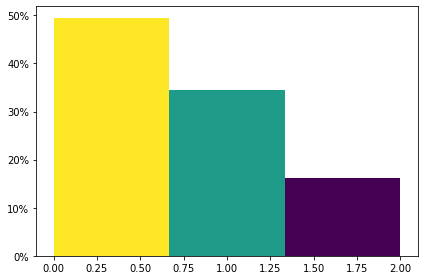

In [196]:
import numpy as np

mu = 3 # Should be 2 dimensions up to 4-5ish max
s = 1.5 # 1 < s <= 2: 1 means NO pressure at all, 2 means worst aint's selected

print("p(LR selection): {}%".format(100 * linear_ranking_selection_probabilities(mu, s)))
rands = []
samples = 5000
for i in range(0, samples):
    rands.append(np.random.choice(mu, 1, p=linear_ranking_selection_probabilities(mu, s)))
rands = np.array(rands)    

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

N_points = x.size
x = rands
n_bins = mu
fig, axs = plt.subplots(1, 1, tight_layout=True)

N, bins, patches = axs.hist(x, bins=n_bins)  # N is the count in each bin, bins is the lower-limit of the bin
fracs = N / N.max()  # We'll color code by height, but you could use any scalar
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axs.hist(x, bins=n_bins, density=True)  # We can also normalize our inputs by the total number of counts
axs.yaxis.set_major_formatter(PercentFormatter(xmax=samples))

Probability based random choice:

In [56]:
mu = 4
rank_fit = 2 # Best: 0, worst: mu -1
s = 1.5 # 1 < s <= 2

print("p(LR ranked: {}): {}%".format(rank_fit, 100 * linear_ranking_selection_probabilities(mu, s, rank_fit)))

p(LR ranked: 2): [37.5        29.16666667 20.83333333 12.5       ]%


In [ ]:
##### import matplotlib.pyplot as plt
import numpy as np

def samplemat(dims, kk, index_nD):
    aa = np.zeros(dims)
    for k in kk:
        aa[k[0], k[1]] = 2
    aa[index_nD[0], index_nD[1]] = 1
    return aa

CA_dimensions = [3, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 3

index_1D = 14
index_1D = min(index_1D, max_ranks - 1)
mat = samplemat(
    CA_dimensions, get_nD_neighbours(index_1D, max_ranks, CA_dimensions), 
    get_1D_to_nD(index_1D, max_ranks, CA_dimensions))

plt.matshow(mat)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def samplemat(dims, kk, index_nD):
    aa = np.zeros(dims)
    for k in kk:
        aa[k[0], k[1], k[2]] = 2
    aa[index_nD[0], index_nD[1], index_nD[2]] = 1.65
    return aa

CA_dimensions = [8, 8, 2]
all_ranks = CA_dimensions[0] * CA_dimensions[1] * CA_dimensions[2]
max_ranks = all_ranks - 12

print((CA_dimensions[0] * CA_dimensions[1] * CA_dimensions[2]) - 1)
index_1D = 114

index_1D = min(index_1D, max_ranks - 1)
mat = samplemat(
    CA_dimensions, get_nD_neighbours(index_1D, max_ranks, CA_dimensions), 
    get_1D_to_nD(index_1D, max_ranks, CA_dimensions))


X, Y, Z = np.mgrid[0:CA_dimensions[0], 0:CA_dimensions[1], 0:CA_dimensions[2]]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(X, Y, Z, c=mat.flatten(), alpha=0.5)
fig.colorbar(scat, shrink=0.5, aspect=5)

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

# x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()

# trace1 = go.Scatter3d(
#     x=x,
#     y=y,
#     z=z,
#     mode='markers',
#     marker=dict(
#         size=12,
#         line=dict(
#             color='rgba(217, 217, 217, 0.14)',
#             width=0.5
#         ),
#         opacity=0.8
#     )
# )

# x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
x2, y2, z2 = np.mgrid[0:CA_dimensions[0], 0:CA_dimensions[1], 0:CA_dimensions[2]]
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X, Y, Z = np.mgrid[-1:1:10j, -1:1:10j, -1:1:10j]

T = np.exp(-X**2 - Y**2 - Z**2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(X, Y, Z, c=Z.flatten(), alpha=0.5)
fig.colorbar(scat, shrink=0.5, aspect=5)

In [ ]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 2
print("max_ranks:", max_ranks)
for i in range (0, max_ranks):
    neighbours_1D = get_1D_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(neighbours_1D, i))

In [ ]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 0
for i in range (0, all_ranks):
    neighbours_1D = get_1D_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(neighbours_1D, i))

In [ ]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 2
for i in range (0, all_ranks):
    nD_neighbours = get_nD_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(nD_neighbours, i))

In [ ]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 0
for i in range (0, all_ranks):
    nD_neighbours = get_nD_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(nD_neighbours, i))

In [ ]:
CA_dimensions = [3, 6]
max_ranks = 3 * 6
for i in range (0, 3 * 6):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))

In [ ]:
CA_dimensions = [3, 6, 2]
max_ranks = 3 * 6 * 2
for i in range (0, max_ranks):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)\
    
    print("{}: {}({})".format(nD, i,  i))
    

In [ ]:
CA_dimensions = [6, 3, 4, 2, 5]
max_ranks = 3 * 4 * 2 * 5 * 6

for i in range (0, 3 * 4 * 2 * 5 * 6):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))
#     print("{}: {}({})".format(nD, i, i))

In [ ]:
CA_dimensions = [3, 4, 2, 5]
for i in range (0, 3 * 4 * 2 * 5):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))
#     print("{}: {}({})".format(nD, i, i))

In [ ]:
CA_dimensions = [3, 6, 2]
for i in range (0, 3 * 6 * 2):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))

In [ ]:
CA_dimensions = [3, 6, 2, 3]
max_ranks = 108

for l in range (0, CA_dimensions[3]):
    for k in range (0, CA_dimensions[2]):
        for i in range(0, CA_dimensions[0]):   
            for j in range(0, CA_dimensions[1]):             
                index_nD = [i, j, k, l]
                print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

In [ ]:
CA_dimensions = [3, 6, 2]

for k in range (0, CA_dimensions[2]):
    for i in range(0, CA_dimensions[0]):   
        for j in range(0, CA_dimensions[1]):             
            index_nD = [i, j, k]
            print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

In [ ]:
CA_dimensions = [3, 6]
for i in range(0, CA_dimensions[0]):
    for j in range(0, CA_dimensions[1]):
        index_nD = [i, j]
        print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

In [ ]:
CA_dimensions = [3, 2, 2, 3, 2, 3]
max_ranks = 108 * 2

for y in range (0, CA_dimensions[5]):
    for x in range (0, CA_dimensions[4]):
        for l in range (0, CA_dimensions[3]):
            for k in range (0, CA_dimensions[2]):
                for i in range(0, CA_dimensions[0]):   
                    for j in range(0, CA_dimensions[1]):             
                        index_nD = [i, j, k, l, x, y]
                        print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

In [ ]:
CA_dimensions = [3, 6, 2, 3, 2]
max_ranks = 108 * 2

for x in range (0, CA_dimensions[4]):
    for l in range (0, CA_dimensions[3]):
        for k in range (0, CA_dimensions[2]):
            for i in range(0, CA_dimensions[0]):   
                for j in range(0, CA_dimensions[1]):             
                    index_nD = [i, j, k, l, x]
                    print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

In [ ]:
CA_dimensions = [3, 6, 2]
max_ranks = 27
index_nD = [1, 3, 1]
returned_1D = get_nD_to_1D(index_nD, max_ranks, CA_dimensions)
print("index_nD: {}, returned_1D: {}".format(index_nD, returned_1D))

CA_dimensions = [3, 6]
max_ranks = 18
index_nD = [2, 2]
returned_1D = get_nD_to_1D(index_nD, max_ranks, CA_dimensions)
print("index_nD: {}, returned_1D: {}".format(index_nD, returned_1D))

CA_dimensions = [3, 6]
max_ranks = 18
index_nD = [1, 2]
returned_1D = get_nD_to_1D(index_nD, max_ranks, CA_dimensions)
print("index_nD: {}, returned_1D: {}".format(index_nD, returned_1D))


In [ ]:
CA_dimensions = [3, 6, 2]
max_ranks = 27
index_1D = 27
index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)

In [ ]:
CA_dimensions = [3, 6, 2, 3]
max_ranks = 108

index_1D = 107
index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)